# Relative Encodings

In [33]:
import numpy as np
import pandas as pd
import edit_distance
from sklearn import linear_model, preprocessing
from sklearn.linear_model import HuberRegressor, Ridge
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib as mpl
#make sure to install keras if you don't have the package yet
from keras import layers, models

In [34]:
DATA_PATH = "../cr4_no_ceiling.csv"
ENERGIES_PATH = "subopt_attributes4_with_structure.csv"
WINDOWS_PATH = "../vienna_windows4.csv"

In [35]:
# Time to load in the data
data = pd.read_csv(DATA_PATH)
energies = pd.read_csv(ENERGIES_PATH)
energies = energies.drop(['mfold_opt', 'mfold_worst', 'mfold_mean', 'mfold_samples', 'mfold_std',
                          'mfold_skew','mfold_median'], axis=1)
energies["sequence"] = energies.Sequence.str.slice(29, -32).str.replace("U", "T")
windows = pd.read_csv(WINDOWS_PATH)
windows["sequence"] = windows['0'].str.slice(29, -32).str.replace("U", "T")
big_table = pd.merge(energies, data, on='sequence', how="inner")
big_table = pd.merge(big_table, windows, on='sequence', how="inner")

#columns list needed when we add data later
cols = list(energies.columns)
cols.remove('Sequence')
cols.remove('sequence')

def thresh(val):
    if val < 1 or val > 128:
        return 128
    else:
        return val

big_table['kd'] = big_table['kd'].apply(thresh)
#modify KD values based on thresholding

#now we want to add the ABA column to big_table
perfect_sequence = "CCATAGAGAGGTTATCCGCTCA"
PERFECT_KD = big_table[big_table['sequence'] == perfect_sequence].iloc[0]['kd']
PERFECT_SEQ = big_table[big_table['sequence'] == perfect_sequence].iloc[0]['Sequence']
big_table['ABA'] = -(big_table.kd/PERFECT_KD).apply(np.log)
big_table.head()

#This function recovers the sequence of changes (insertions/deletions/replacements)
#from the perfect sequence to the target sequence
def get_diff(perfect, x):
    output = []
    sm = edit_distance.SequenceMatcher(a=perfect, b=x)
    for row in sm.get_opcodes():
        if row[0] == "equal":
            continue
        elif row[0] == "insert":
            output.append((row[1], "insert", x[row[3]]))
        elif row[0] == "delete":
            output.append((row[1], "delete"))
        else:
            output.append((row[1], "replace", x[row[3]]))
    return output



# want to create a value mapping table of the changes
# the structure goes like this:
# [(index, i, A), (index, i, C), (index, i, G), (index, i  T),
#  (index, r, A), (index, r, C), (index, r, G), (index, r, T), (index, d)]
# index is the position on the rna, i is insertion, r is replacement, d is deletion,
# In the future we can try to have a way to combine these variables
def get_action(coord):
    if (coord % 9) == 0:
        return "INS A"
    if (coord % 9) == 1:
        return "INS C"
    if (coord % 9) == 2:
        return "INS G"
    if (coord % 9) == 3:
        return "INS T"
    if (coord % 9) == 4:
        return "REP A"
    if (coord % 9) == 5:
        return "REP C"
    if (coord % 9) == 6:
        return "REP G"
    if (coord % 9) == 7:
        return "REP T"
    if (coord % 9) == 8:
        return "DEL"
    

def get_position(coord):
    if len(coord) == 2:
        return coord[0]*9+8
    elif coord[1] == 'insert' and coord[2] == 'A':
        return coord[0]*9
    elif coord[1] == 'insert' and coord[2] == 'C':
        return coord[0]*9 + 1
    elif coord[1] == 'insert' and coord[2] == 'G':
        return coord[0]*9 + 2
    elif coord[1] == 'insert' and coord[2] == 'T':
        return coord[0]*9 + 3
    elif coord[1] == 'replace' and coord[2] == 'A':
        return coord[0]*9 + 4
    elif coord[1] == 'replace' and coord[2] == 'C':
        return coord[0]*9 + 5
    elif coord[1] == 'replace' and coord[2] == 'G':
        return coord[0]*9 + 6
    elif coord[1] == 'replace' and coord[2] == 'T':
        return coord[0]*9 + 7
    else:
        print ("INCORRECT COORDINATE")
        return -1
#Plots detailed results
def display(predicted, actual, title="Predicted vs Actual"):
    x,y = actual,predicted
    
    
    
    # definitions for the axes
    left, width = 0.02, 0.65
    bottom, height = 0.2, 0.65
    spacing = 0.02


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))
    #plt.title("Predicted vs Expected ABA for Linear Regression Model")



    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    #ax_scatter.scatter(predicted, actual)
    ax_scatter.hexbin(x, y, gridsize=(int(30/1.5),int(15/1.5)),  cmap='Purples', edgecolors='none' )
    ax_scatter.plot(np.unique(predicted), np.poly1d(np.polyfit(x,
                                                x, 1))(np.unique(y)))

    ax_scatter.set_xlabel("Fit (ABA)", fontsize=15)
    ax_scatter.set_ylabel("Measured (ABA)", fontsize=15)
    # now determine nice limits by hand:
    binwidth = 0.25
    lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
    #ax_scatter.set_xlim((-lim, lim))
    #ax_scatter.set_ylim((-lim, lim))

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins,  color=(0.23, 0.06, 0.4))
    ax_histx.set_title(title,pad=15, fontsize=20)
    ax_histy.hist(y, bins=bins, orientation='horizontal',color=(0.23, 0.06, 0.4))

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    

    plt.show()
# to help analyze results (older version)
def display1(predicted, actual, title="Predicted vs Actual"):
    #plt.scatter(predicted, actual)
    plt.figure(num=1,figsize=(5,5))
    plt.hexbin(predicted, actual, gridsize=(15,15),  cmap='Purples', edgecolors='none' )
    plt.plot(np.unique(predicted), np.poly1d(np.polyfit(actual,
                                                actual, 1))(np.unique(predicted)))
    #plt.show()
    plt.xlabel("predicted ABA")
    plt.ylabel("actual ABA")
    plt.title(title)
    plt.show()
    #now we build the table that we will use for regressions
#think of data_matrix as input and output variable as output
#seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
def create_matrix(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
    
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(9*len(perfect_sequence))]
                for coord in coords:
                    row[get_position(coord)] = 1
                #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y


def create_matrix_0(randomize=True):
    max_len = 0
    for seq in seq_aba_pairs:
        max_len = max(max_len, len(seq))
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            #coords = get_diff(perfect_sequence, seq)
            #if len(coords) > 5:
            #    pass
            #else:
            row = [0 for i in range(4*max_len)]
            for i in range(len(seq)):
                if seq[i] == 'A':
                    row[i*4 + 0] = 1
                elif seq[i] == 'C':
                    row[i*4 + 1] = 1
                elif seq[i] == 'G':
                    row[i*4 + 2] = 1
                elif seq[i] == 'T':
                    row[i*4 + 3] = 1
                else:
                    print("Impossible happened check seq values", seq)
                #row[get_position(coord)] = 1
            #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
            pruned_combined_data_matrix.append(row)
            pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    if randomize:
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]
    
    return X, y

def shuffle(X, y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

def create_matrix2(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            if len(coords) > 5:
                pass
            else:
                for coord in coords:
                    row[get_position(coord)] = 1
                #append the value of the energy levels
                row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                print(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                #row.extend(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])

    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y

# the start of this function is same as before
def create_matrix3(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            if len(coords) > 5:
                pass
            else:
                for coord in coords:
                    row[get_position(coord)] = 1
                #append the value of the energy levels
                #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                #row.extend(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    
    #these are pooling values
    X_add = []
    for row in X:
        add_row = []
        #adding pooling for each position
        for gene in range(int(len(X[0])/9)):
            add_row.extend([max(row[gene*9: (gene+1)*9]), min(row[gene*9: (gene+1)*9]),
                           sum(row[gene*9: (gene+1)*9])])
        #adding pooling for group of three nucleutide positions
        for gene in range(int(len(X[0])/27)):
            add_row.extend([max(row[gene*27: (gene+1)*27]), min(row[gene*27: (gene+1)*27]),
                           sum(row[gene*27: (gene+1)*27])])
        #adding pooling for group of six nucleutide positions
        for gene in range(int(len(X[0])/54)):
            add_row.extend([max(row[gene*54: (gene+1)*54]), min(row[gene*54: (gene+1)*54]),
                           sum(row[gene*54: (gene+1)*54])])
        for gene in range(int(len(X[0])/108)):
            add_row.extend([max(row[gene*99: (gene+1)*99]), min(row[gene*99: (gene+1)*99]),
                           sum(row[gene*99: (gene+1)*99])])
        for i in range(9):
            sub_list = [row[gene*9: (gene+1)*9][i] for gene in range(int(len(X[0])/9))]
            add_row.extend([max(sub_list), min(sub_list),sum(sub_list)])
            #add_row.extend([max(sub_list)**2, min(sub_list)**2,sum(sub_list)**2])
        X_add.append(add_row)
    X_add = np.array(X_add)
    
    
    X = np.append(X, X_add, axis=1)
    
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y
# the start of this function is same as before
def create_matrix4(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
    max_len = 0
    for seq in seq_aba_pairs:
        max_len = max(max_len, len(seq))
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            if len(coords) > 6:
                pass
            else:
                for coord in coords:
                    row[get_position(coord)] = 1
                #append the value of the energy levels
                row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                #row.extend(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    
    #these are pooling values
    X_add = []
    for row in X:
        add_row = []
        #adding pooling for each position
        for gene in range(int(len(X[0])/9)):
            add_row.extend([max(row[gene*9: (gene+1)*9]), min(row[gene*9: (gene+1)*9]),
                           sum(row[gene*9: (gene+1)*9])])
        #adding pooling for group of three nucleutide positions
        for gene in range(int(len(X[0])/27)):
            add_row.extend([max(row[gene*27: (gene+1)*27]), min(row[gene*27: (gene+1)*27]),
                           sum(row[gene*27: (gene+1)*27])])
        #adding pooling for group of six nucleutide positions
        for gene in range(int(len(X[0])/54)):
            add_row.extend([max(row[gene*54: (gene+1)*54]), min(row[gene*54: (gene+1)*54]),
                           sum(row[gene*54: (gene+1)*54])])
        for gene in range(int(len(X[0])/108)):
            add_row.extend([max(row[gene*99: (gene+1)*99]), min(row[gene*99: (gene+1)*99]),
                           sum(row[gene*99: (gene+1)*99])])
        for i in range(9):
            sub_list = [row[gene*9: (gene+1)*9][i] for gene in range(int(len(X[0])/9))]
            add_row.extend([max(sub_list), min(sub_list),sum(sub_list)])
        
        row = [0 for i in range(4*max_len)]
        for i in range(len(seq)):
            if seq[i] == 'A':
                row[i*4 + 0] = 1
            elif seq[i] == 'C':
                row[i*4 + 1] = 1
            elif seq[i] == 'G':
                row[i*4 + 2] = 1
            elif seq[i] == 'T':
                row[i*4 + 3] = 1
            else:
                print("Impossible happened check seq values", seq)
        #add_row.extend(row) big change to not include absolute representation
        X_add.append(add_row)
        
    X_add = np.array(X_add)
    
    
    X = np.append(X, X_add, axis=1)
    #X = np.append(X, create_matrix_0(randomize=False)[0], axis=1)
    
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    y = preprocessing.scale(y)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    #np.random.shuffle(indices)
    #X = X[indices]
    #y = y[indices]
    return X, y

In [259]:
#returns a CNN model given training data
def train(X, y, batch_size=100, epochs=100):
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    y_ = y.reshape(len(y), 1)
    print("input shaped", (len(X[0]), 1, 1))
    
    model = models.Sequential()
    #model.add(layers.Conv2D(16, (3, 1), activation='relu', input_shape=(len(X[0]), 1, 1)))
    #model.add(layers.MaxPooling2D((3, 1)))
    model.add(layers.Conv2D(32, (5, 1), activation='relu', input_shape=(len(X[0]), 1, 1)))
    #model.add(layers.MaxPooling2D((3, 1)))
    #model.add(layers.Conv2D(64, (10, 1), activation='relu'))
    model.add(layers.MaxPooling2D((3, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(16, activation="relu"))
    model.add(layers.Dense(1, activation='linear'))
    model.summary()
    
    

    #model.compile(loss='mean_squared_error',
    #              optimizer='sgd')
    model.compile(loss='logcosh',
                  optimizer='sgd')
    model.fit(X_, y_,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1
              )
    return model

#fits the data based on the trained model from above
def fit(model, X, y):
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    display(model.predict(X_).reshape(len(X_)), y, title = "CNN on all Features vs True ABA")
    
    corr, p_value = pearsonr((model.predict(X_).reshape(len(X_))), y)
    print("corr is", corr)
    return corr
    #return vhinge((model.predict(X_)).reshape(len(X_))), y
    
# no longer necessary  
def without_outliers(model, X, y):
    outliers = []
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    predictions = vhinge((model.predict(X_)).reshape(len(X_)))
    for i in range(len(predictions)):
        if predictions[i]-y[i] > 3:
            print("removing", predictions[i], y[i])
            predictions = np.delete(predictions, i)
            y.pop(i)

In [43]:
#free energy bonds
def dots_to_features(string):
    arr = []
    for char in string:
        if char == '.':
            arr.append(0)
        elif char == ')' or char == '(':
            arr.append(1)
    return arr

def generate_structure_matrix(table):
    X, y = [],[]
    for i, row in table.iterrows():
        ss = row['structure']
        X.append(dots_to_features(ss))
        y.append(row['ABA'])
    return np.array(X), np.array(y)

In [152]:
# the start of this function is same as before
def create_matrix5(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
    max_len = 0
    for seq in seq_aba_pairs:
        max_len = max(max_len, len(seq))
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            if len(coords) > 6:
                pass
            else:
                for coord in coords:
                    row[get_position(coord)] = 1
                #append the value of the energy levels
                row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                
                
                #now we add structure
                ss = big_table[big_table['sequence'] == seq].iloc[0]['structure']
                row.extend(dots_to_features(ss))
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    
    #these are pooling values
    X_add = []
    for row in X:
        add_row = []
        
        #adding pooling for each position
        for gene in range(int((len(X[0])-len(perfect_sequence)-1)/9)):
            add_row.extend([max(row[gene*9: (gene+1)*9]), min(row[gene*9: (gene+1)*9]),
                           sum(row[gene*9: (gene+1)*9])])
        #adding pooling for group of three nucleutide positions
        for gene in range(int((len(X[0])-len(perfect_sequence)-1)/27)):
            add_row.extend([max(row[gene*27: (gene+1)*27]), min(row[gene*27: (gene+1)*27]),
                           sum(row[gene*27: (gene+1)*27])])
        #adding pooling for group of six nucleutide positions
        for gene in range(int((len(X[0])-len(perfect_sequence)-1)/54)):
            add_row.extend([max(row[gene*54: (gene+1)*54]), min(row[gene*54: (gene+1)*54]),
                           sum(row[gene*54: (gene+1)*54])])
        for gene in range(int((len(X[0])-len(perfect_sequence)-1)/108)):
            add_row.extend([max(row[gene*99: (gene+1)*99]), min(row[gene*99: (gene+1)*99]),
                           sum(row[gene*99: (gene+1)*99])])
        
        for i in range(9):
            sub_list = [row[gene*9: (gene+1)*9][i] for gene in range(int(len(X[0])/9))]
            add_row.extend([max(sub_list), min(sub_list),sum(sub_list)])
        
        row = [0 for i in range(4*max_len)]
        for i in range(len(seq)):
            if seq[i] == 'A':
                row[i*4 + 0] = 1
            elif seq[i] == 'C':
                row[i*4 + 1] = 1
            elif seq[i] == 'G':
                row[i*4 + 2] = 1
            elif seq[i] == 'T':
                row[i*4 + 3] = 1
            else:
                print("Impossible happened check seq values", seq)
        #add_row.extend(row) big change to not include absolute representation
        X_add.append(add_row)
        
    X_add = np.array(X_add)
    
    
    X = np.append(X, X_add, axis=1)
    
    
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    y = preprocessing.scale(y)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

In [153]:
big_table.structure.head()

0      .....((((((....)))))).
1        .......(((......))).
2    ........((((.....))))...
3    ..........((....))......
4      .....((((.....))))....
Name: structure, dtype: object

In [154]:
filt_table = big_table[big_table.structure.str.len() == 22]

In [155]:
big_table.head()

,vienna_opt,vienna_worst,vienna_mean,vienna_samples,vienna_std,vienna_skew,vienna_median,vienna_worst_100,vienna_mean_100,Sequence,...,delta_y,count,0,0.1,1,5,10,20,40,ABA
0,-21.9,-16.9,-17.643825,2097,0.751334,-1.611854,-17.4,-19.200001,-19.856,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUGGAGAGGUUAUCC...,...,54588.826130,48,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUGGAGAGGUUAUCC...,-9.7,-9.7,-9.7,-13.3,-15.3,-21.9,-2.544516
1,-23.9,-18.9,-19.735792,1288,0.838893,-1.601279,-19.5,-21.100000,-21.820,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGAUCCGC...,...,59918.760269,82,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGAUCCGC...,-2.8,-2.8,-2.8,-5.4,-12.1,-23.9,-2.698243
2,-15.5,-10.5,-11.225309,10127,0.724902,-1.580592,-11.0,-13.700000,-14.197,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUAUCC...,...,73849.033521,63,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUAUCC...,-2.9,-2.9,-3.2,-7.7,-9.3,-15.5,-1.252099
3,-19.5,-14.5,-15.347548,4894,0.831892,-1.490905,-15.1,-17.700001,-18.254,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAUGAGGUUAUC...,...,32693.782873,65,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAUGAGGUUAUC...,-0.7,-1.1,-1.5,-5.8,-13.2,-19.5,-2.698243
4,-15.7,-10.7,-11.386458,4630,0.699062,-1.641765,-11.2,-13.400000,-13.914,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUACUCUCCAAUAGG...,...,35328.098104,73,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUACUCUCCAAUAGG...,-1.1,-1.1,-1.5,-5.7,-11.1,-15.7,-2.126603


In [156]:
filt_table.shape

(2351, 25)

In [157]:
X, y = create_matrix5(filt_table, perfect_sequence)

In [158]:
len(X[0]) #362 features

347

In [149]:
# get feature from column given this SPECIFIC DATASET Target4 (need to update for other targets)
def feature_label(col, perfect_seq = perfect_sequence):
    if col < len(perfect_sequence)*9:
        return "pos " + str(int(col/9) + 1) + " " + get_action(col)
    elif col == len(perfect_sequence)*9:
        return "free energy"
    elif col < len(perfect_sequence)*9 + 1 + len(perfect_sequence):
        return "paired/free base " + str(col- len(perfect_sequence)*9)
    else:
        return "pool feature" + str(col- len(perfect_sequence)*10)

In [143]:
for i in range(221):
    print(i, feature_label(i))

0 pos 1 INS A
1 pos 1 INS C
2 pos 1 INS G
3 pos 1 INS T
4 pos 1 REP A
5 pos 1 REP C
6 pos 1 REP G
7 pos 1 REP T
8 pos 1 DEL
9 pos 2 INS A
10 pos 2 INS C
11 pos 2 INS G
12 pos 2 INS T
13 pos 2 REP A
14 pos 2 REP C
15 pos 2 REP G
16 pos 2 REP T
17 pos 2 DEL
18 pos 3 INS A
19 pos 3 INS C
20 pos 3 INS G
21 pos 3 INS T
22 pos 3 REP A
23 pos 3 REP C
24 pos 3 REP G
25 pos 3 REP T
26 pos 3 DEL
27 pos 4 INS A
28 pos 4 INS C
29 pos 4 INS G
30 pos 4 INS T
31 pos 4 REP A
32 pos 4 REP C
33 pos 4 REP G
34 pos 4 REP T
35 pos 4 DEL
36 pos 5 INS A
37 pos 5 INS C
38 pos 5 INS G
39 pos 5 INS T
40 pos 5 REP A
41 pos 5 REP C
42 pos 5 REP G
43 pos 5 REP T
44 pos 5 DEL
45 pos 6 INS A
46 pos 6 INS C
47 pos 6 INS G
48 pos 6 INS T
49 pos 6 REP A
50 pos 6 REP C
51 pos 6 REP G
52 pos 6 REP T
53 pos 6 DEL
54 pos 7 INS A
55 pos 7 INS C
56 pos 7 INS G
57 pos 7 INS T
58 pos 7 REP A
59 pos 7 REP C
60 pos 7 REP G
61 pos 7 REP T
62 pos 7 DEL
63 pos 8 INS A
64 pos 8 INS C
65 pos 8 INS G
66 pos 8 INS T
67 pos 8 REP A
68 p

In [144]:
X[:,9*22]

array([-1.03555892,  1.15585551, -1.08425722, ...,  0.08449721,
        1.59413876, -0.74337101])

In [145]:
len(X[:][i])

248

In [146]:
feature_label(200)

'paired/free base 2'

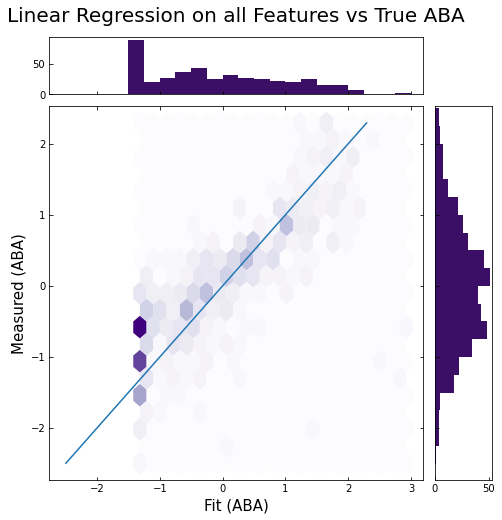

test correlation is 0.7830342767626568


In [147]:
#just to show that we aren't really over-fitting
X, y = shuffle(X,y)
cutoff = 1800

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)

input shaped (347, 1, 1)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 343, 1, 32)        192       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 114, 1, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 3648)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                58384     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 58,593
Trainable params: 58,593
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
18/18 [==============================] - 0s 7ms/step - loss: 0.3743
Epoch 2/50

18/18 [==============================] - 0s 8ms/step - loss: 0.0774
Epoch 90/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0746
Epoch 91/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0743
Epoch 92/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0782
Epoch 93/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0860
Epoch 94/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0821
Epoch 95/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0786
Epoch 96/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0833
Epoch 97/500
18/18 [==============================] - 0s 8ms/step - loss: 0.0776
Epoch 98/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0749
Epoch 99/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0705
Epoch 100/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0815
Epoch 101/500
18/18 [===================

18/18 [==============================] - 0s 7ms/step - loss: 0.0655
Epoch 190/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0681
Epoch 191/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0653
Epoch 192/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0626
Epoch 193/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0609
Epoch 194/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0614
Epoch 195/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0648
Epoch 196/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0644
Epoch 197/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0621
Epoch 198/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0641
Epoch 199/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0645
Epoch 200/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0657
Epoch 201/500
18/18 [=========

18/18 [==============================] - 0s 7ms/step - loss: 0.0598
Epoch 290/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0591
Epoch 291/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0499
Epoch 292/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0587
Epoch 293/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0597
Epoch 294/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0573
Epoch 295/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0590
Epoch 296/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0584
Epoch 297/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0576
Epoch 298/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0577
Epoch 299/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0513
Epoch 300/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0620
Epoch 301/500
18/18 [=========

18/18 [==============================] - 0s 7ms/step - loss: 0.0503
Epoch 390/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0567
Epoch 391/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0575
Epoch 392/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0516
Epoch 393/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0503
Epoch 394/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0454
Epoch 395/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0457
Epoch 396/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0507
Epoch 397/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0496
Epoch 398/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0473
Epoch 399/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0511
Epoch 400/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0545
Epoch 401/500
18/18 [=========

18/18 [==============================] - 0s 7ms/step - loss: 0.0503
Epoch 490/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0463
Epoch 491/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0483
Epoch 492/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0443
Epoch 493/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0472
Epoch 494/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0542
Epoch 495/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0472
Epoch 496/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0422
Epoch 497/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0485
Epoch 498/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0445
Epoch 499/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0520
Epoch 500/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0473


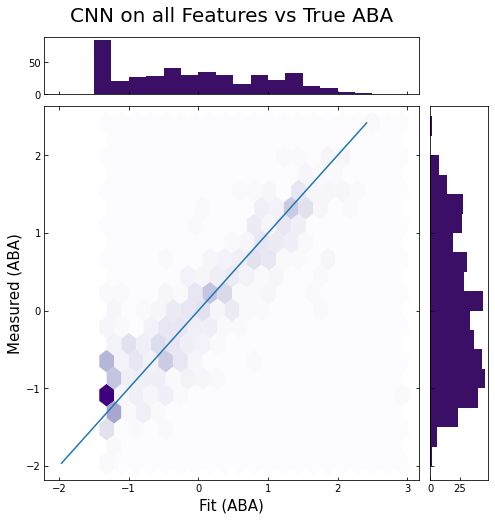

corr is 0.8815271969801101


0.8815271969801101

In [269]:
X, y = shuffle(X, y)
#this will take 5 minutes to run
X_train = X[:cutoff]
X_test = X[cutoff:]

y_train = y[:cutoff]
y_test = y[cutoff:]

model = train(X_train, y_train, epochs=500)
fit(model, X_test, y_test)

In [155]:
X, y = create_matrix5(filt_table, perfect_sequence)

In [147]:
len(X)

2235

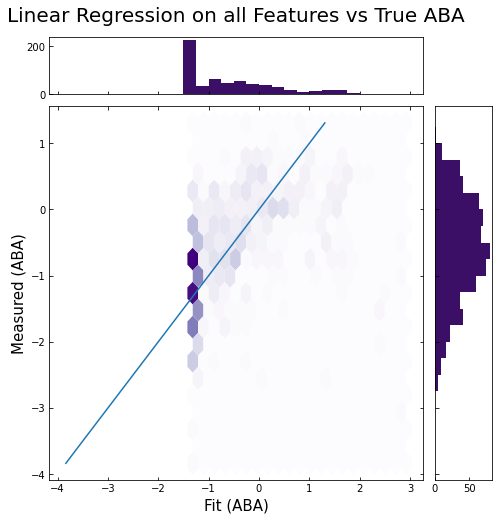

test correlation is 0.4535143866294594


In [162]:
#just to show that we aren't really over-fitting
cutoff = 1600

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)

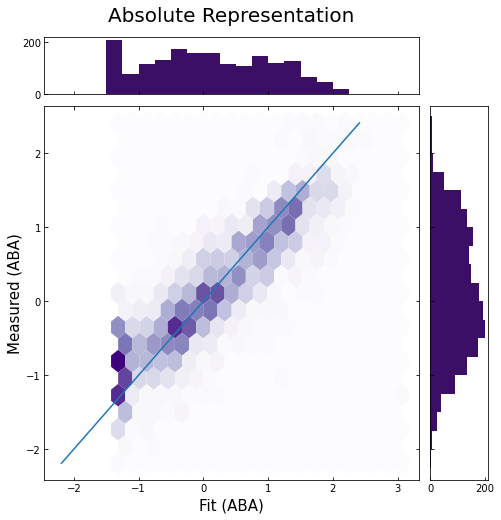

In [151]:
display(reg.predict(X_train), y_train, title="Absolute Representation")

In [154]:
corr, p_value = pearsonr(reg.predict(X_train), y_train)
print("test correlation is",corr)

test correlation is 0.8666438912611101


input shaped (325, 1, 1)
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 321, 1, 32)        192       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 107, 1, 32)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 3424)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 16)                54800     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 17        
Total params: 55,009
Trainable params: 55,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
16/16 [==============================] - 0s 8ms/step - loss: 0.3973
Epoch 2/20

16/16 [==============================] - 0s 7ms/step - loss: 0.0687
Epoch 190/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0664
Epoch 191/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0705
Epoch 192/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0633
Epoch 193/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0659
Epoch 194/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0696
Epoch 195/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0719
Epoch 196/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0700
Epoch 197/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0715
Epoch 198/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0720
Epoch 199/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0741
Epoch 200/200
16/16 [==============================] - 0s 13ms/step - loss: 0.0622


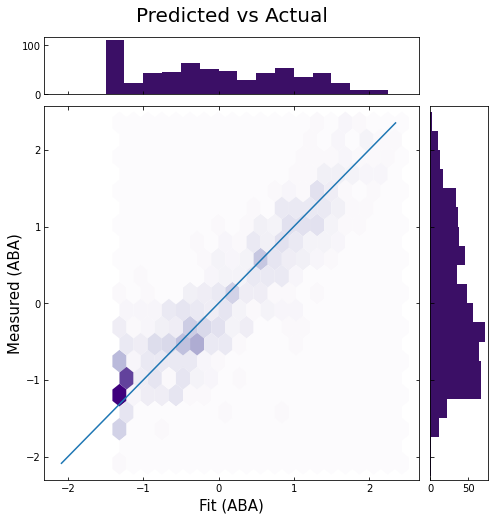

corr is 0.8995470497427164


In [164]:
X, y = shuffle(X, y)
#this will take 5 minutes to run
X_train = X[:cutoff]
X_test = X[cutoff:]

y_train = y[:cutoff]
y_test = y[cutoff:]

model = train(X_train, y_train, epochs=200)
fit(model, X_test, y_test)

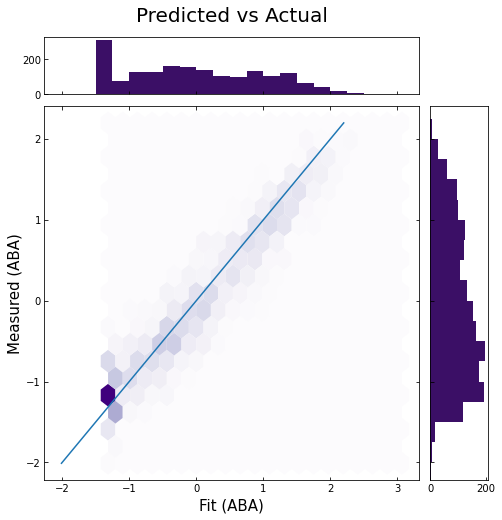

corr is 0.922334999419008


In [138]:
fit(model, X_train, y_train)

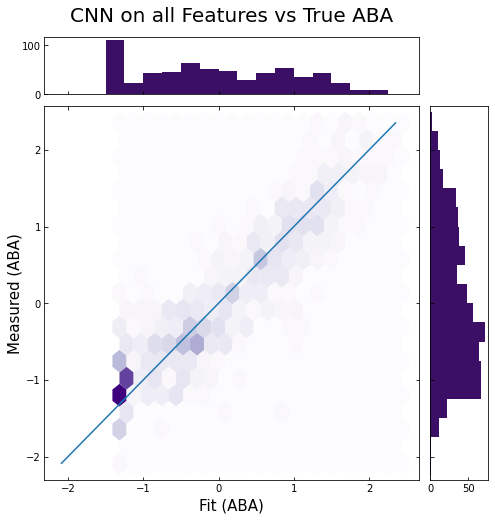

corr is 0.8995470497427164


In [166]:
fit(model, X_test, y_test)

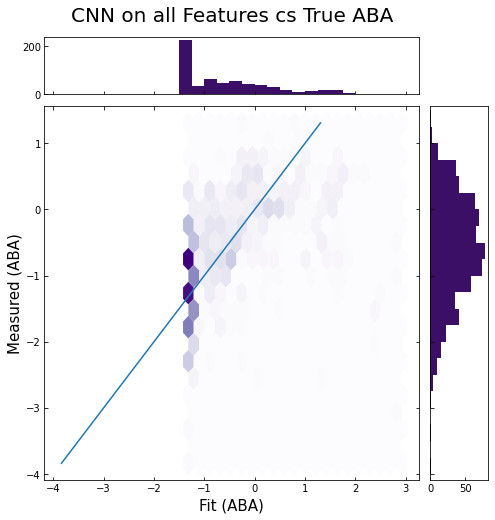

In [163]:
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="CNN on all Features cs True ABA")

In [161]:
X, y = create_matrix4(filt_table, perfect_sequence)

# Venn Diagram of features

In [186]:
X, y = create_matrix5(filt_table, perfect_sequence)

In [187]:
 X[:cutoff, 9*len(perfect_sequence):9*len(perfect_sequence)+1].shape

(1800, 1)

In [189]:
X

array([[ 0.        ,  0.        ,  0.        , ...,  0.29055987,
         0.        ,  0.73450307],
       [ 0.        ,  0.        ,  0.        , ...,  0.29055987,
         0.        ,  0.73450307],
       [ 0.        ,  0.        ,  0.        , ...,  0.29055987,
         0.        , -0.81127316],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.29055987,
         0.        , -0.81127316],
       [ 0.        ,  0.        ,  0.        , ...,  0.29055987,
         0.        , -0.81127316],
       [ 0.        ,  0.        ,  0.        , ...,  0.29055987,
         0.        ,  0.73450307]])

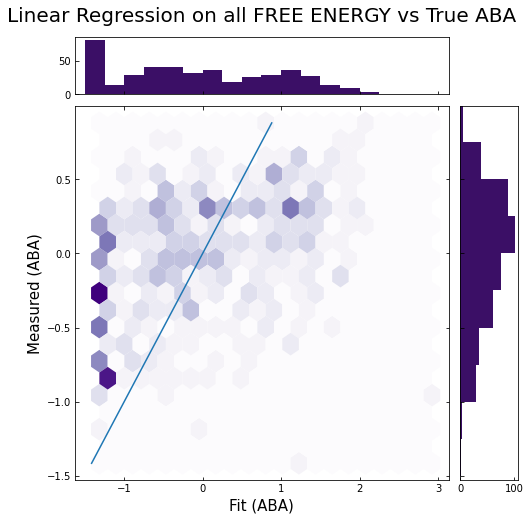

test correlation is 0.40445243898231703


In [286]:
#FREE CORRELATION
X, y = shuffle(X,y)
cutoff = 1800

X_train_free = X[:cutoff, 9*len(perfect_sequence):9*len(perfect_sequence)+1]
y_train = y[:cutoff]


X_test_free = X[cutoff:, 9*len(perfect_sequence):9*len(perfect_sequence)+1]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train_free, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test_free)
display(predicted_output, y_test, title="Linear Regression on all FREE ENERGY vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
ENERGY_CORR = corr

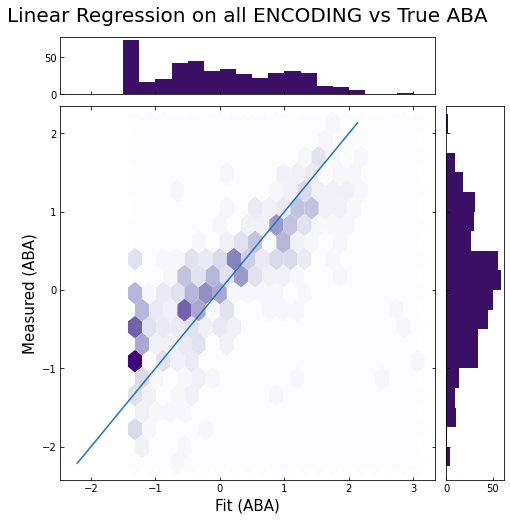

test correlation is 0.7330051458231541


In [226]:
#ENCODING CORRELATION
X, y = shuffle(X,y)
cutoff = 1800

X_train_free = X[:cutoff, :9*len(perfect_sequence)]
y_train = y[:cutoff]


X_test_free = X[cutoff:, :9*len(perfect_sequence)]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train_free, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test_free)
display(predicted_output, y_test, title="Linear Regression on all ENCODING vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
ENC_CORR = corr

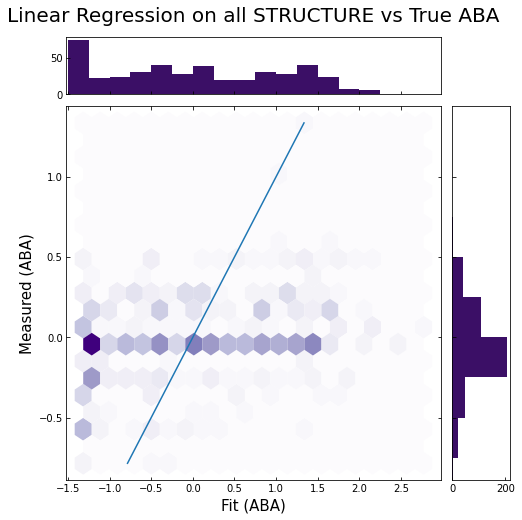

test correlation is 0.3046797876623775


In [234]:
#STRUCTURE CORRELATION
X, y = shuffle(X,y)
cutoff = 1800

X_train_free = X[:cutoff, 9*len(perfect_sequence)+ 1:10*len(perfect_sequence)+ 1]
y_train = y[:cutoff]


X_test_free = X[cutoff:, 9*len(perfect_sequence)+ 1:10*len(perfect_sequence)+ 1]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train_free, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test_free)
display(predicted_output, y_test, title="Linear Regression on all STRUCTURE vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
STRUC_CORR = corr

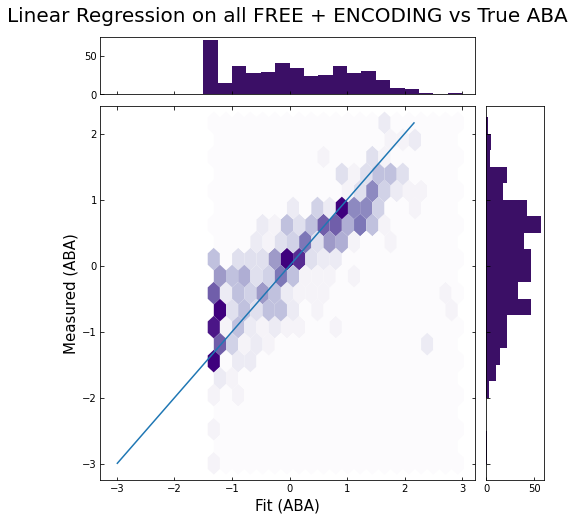

test correlation is 0.7929561549884958


In [224]:
#FREE ENERGY PLUS ENCODING
X, y = shuffle(X,y)

cutoff = 1800
X_train_free = X[:cutoff, :9*len(perfect_sequence) + 1]
y_train = y[:cutoff]


X_test_free = X[cutoff:, :9*len(perfect_sequence)+ 1]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train_free, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test_free)
display(predicted_output, y_test, title="Linear Regression on all FREE + ENCODING vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
ENERGY_ENC_CORR = corr

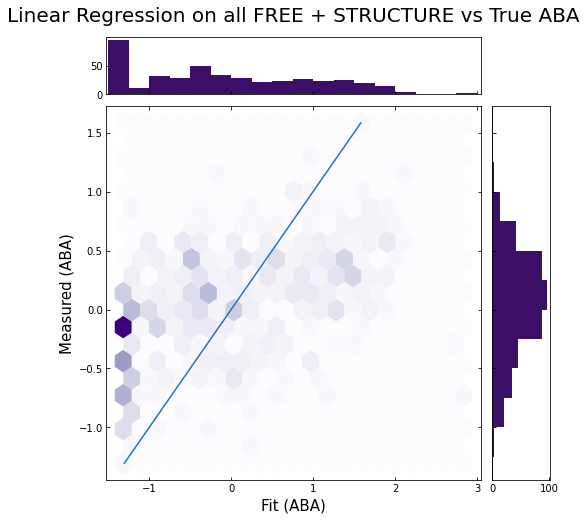

test correlation is 0.4734626548941132


In [221]:
#FREE ENERGY PLUS STRUCTURE
X, y = shuffle(X,y)

cutoff = 1800
X_train_free = X[:cutoff, 9*len(perfect_sequence):10*len(perfect_sequence)+ 1]
y_train = y[:cutoff]


X_test_free = X[cutoff:, 9*len(perfect_sequence):10*len(perfect_sequence)+ 1]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train_free, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test_free)
display(predicted_output, y_test, title="Linear Regression on all FREE + STRUCTURE vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
STRUC_ENERGY_CORR = corr

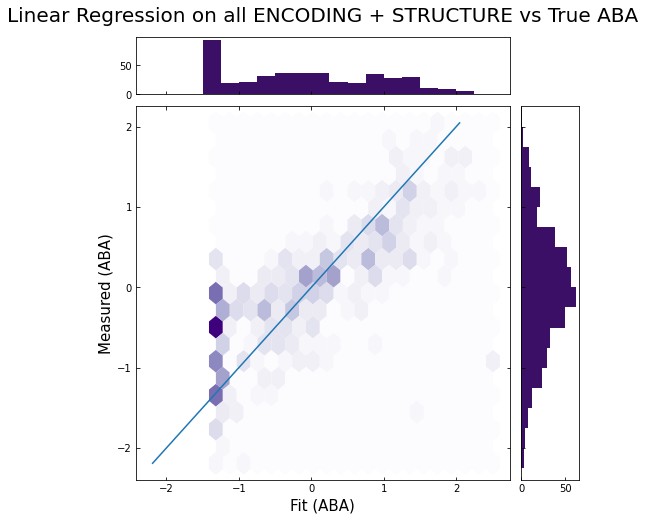

test correlation is 0.7572988659988841


In [247]:
#STRUCTURE PLUS ENCODING
X, y = shuffle(X,y)

cutoff = 1800
X_train_free = X[:cutoff, [i for i in range(10*len(perfect_sequence)+ 1) if i != 9*len(perfect_sequence)]]
y_train = y[:cutoff]


X_test_free = X[cutoff:, [i for i in range(10*len(perfect_sequence)+ 1) if i != 9*len(perfect_sequence)]]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train_free, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test_free)
display(predicted_output, y_test, title="Linear Regression on all ENCODING + STRUCTURE vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
ENC_STRUC_CORR = corr

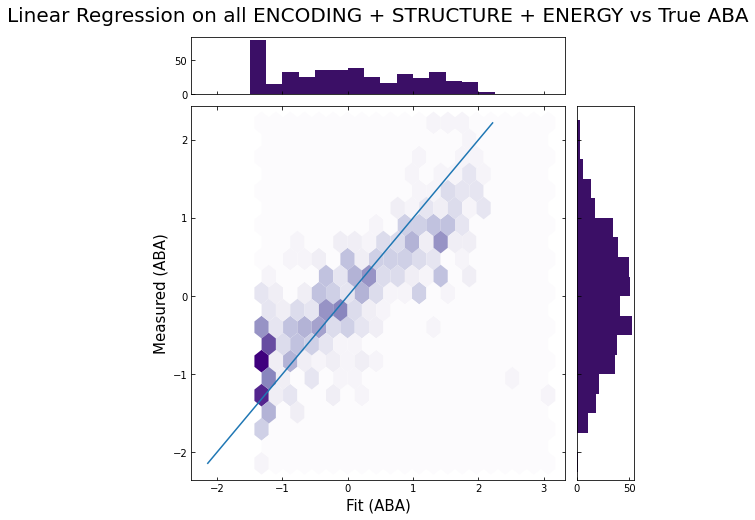

test correlation is 0.8054638856442554


In [220]:
#STRUCTURE PLUS ENCODING PLUS ENERGY
X, y = shuffle(X,y)

cutoff = 1800
X_train_free = X[:cutoff, [i for i in range(10*len(perfect_sequence)+ 1)]]
y_train = y[:cutoff]


X_test_free = X[cutoff:, [i for i in range(10*len(perfect_sequence)+ 1)]]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train_free, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test_free)
display(predicted_output, y_test, title="Linear Regression on all ENCODING + STRUCTURE + ENERGY vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
ENC_STRUC_ENERGY_CORR = corr

<Figure size 1440x1440 with 0 Axes>

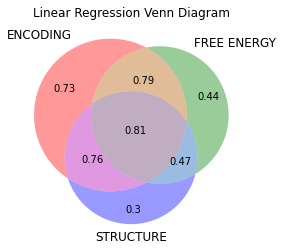

<Figure size 1440x1440 with 0 Axes>

In [256]:
from matplotlib_venn import venn3
plt.title("Linear Regression Venn Diagram")
ENC_CORR, ENERGY_CORR, ENERGY_ENC_CORR, STRUC_CORR= (np.round(ENC_CORR,2),np.round(ENERGY_CORR,2),
                                                     np.round(ENERGY_ENC_CORR,2), np.round(STRUC_CORR,2))
ENC_STRUC_CORR, STRUC_ENERGY_CORR, ENC_STRUC_ENERGY_CORR = (np.round(ENC_STRUC_CORR,2),np.round(STRUC_ENERGY_CORR,2),
                                                     np.round(ENC_STRUC_ENERGY_CORR,2))
venn3(subsets = (ENC_CORR, ENERGY_CORR, ENERGY_ENC_CORR, STRUC_CORR,ENC_STRUC_CORR ,
                 STRUC_ENERGY_CORR, ENC_STRUC_ENERGY_CORR), set_labels = ('ENCODING', 'FREE ENERGY', 'STRUCTURE'))
plt.figure(figsize=(20,20))
#plt.show()

## Now time to do some Neural Net stuff

In [264]:
X, y = create_matrix5(filt_table, perfect_sequence)

input shaped (198, 1, 1)
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 194, 1, 32)        192       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 1, 32)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 16)                32784     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 17        
Total params: 32,993
Trainable params: 32,993
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
18/18 [==============================] - 0s 4ms/step - loss: 0.3764
Epoch 2/10

18/18 [==============================] - 0s 4ms/step - loss: 0.0903
Epoch 90/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0916
Epoch 91/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0956
Epoch 92/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0944
Epoch 93/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0872
Epoch 94/100
18/18 [==============================] - 0s 4ms/step - loss: 0.1036
Epoch 95/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0927
Epoch 96/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0895
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0983
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0990
Epoch 99/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0945
Epoch 100/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0969


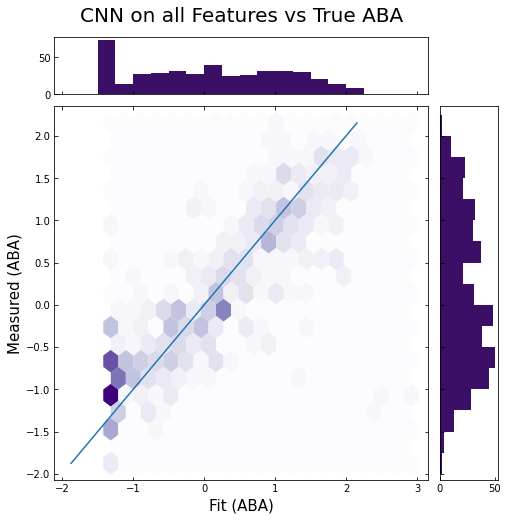

corr is 0.81030069081566


In [272]:
#ENCODING CORRELATION
X, y = shuffle(X,y)
cutoff = 1800

X_train_free = X[:cutoff, :9*len(perfect_sequence)]
y_train = y[:cutoff]


X_test_free = X[cutoff:, :9*len(perfect_sequence)]
y_test = y[cutoff:]

model = train(X_train_free, y_train, epochs=100)

ENC_CORR = fit(model, X_test_free, y_test)

input shaped (22, 1, 1)
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 18, 1, 32)         192       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 1, 32)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 192)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 16)                3088      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 17        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
18/18 [==============================] - 0s 1ms/step - loss: 0.4073
Epoch 2/100
1

18/18 [==============================] - 0s 1ms/step - loss: 0.3402
Epoch 90/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3406
Epoch 91/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3310
Epoch 92/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3271
Epoch 93/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3428
Epoch 94/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3427
Epoch 95/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3332
Epoch 96/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3444
Epoch 97/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3386
Epoch 98/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3558
Epoch 99/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3359
Epoch 100/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3448


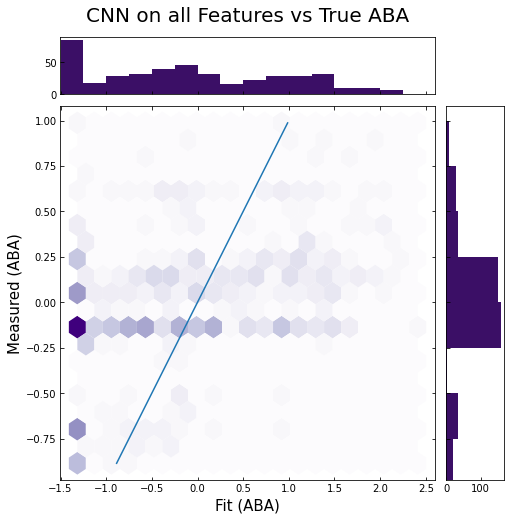

corr is 0.377032311669502


In [273]:
#STRUCTURE CORRELATION
X, y = shuffle(X,y)
cutoff = 1800

X_train_free = X[:cutoff, 9*len(perfect_sequence)+ 1:10*len(perfect_sequence)+ 1]
y_train = y[:cutoff]


X_test_free = X[cutoff:, 9*len(perfect_sequence)+ 1:10*len(perfect_sequence)+ 1]
y_test = y[cutoff:]

model = train(X_train_free, y_train, epochs=100)

STRUC_CORR = fit(model, X_test_free, y_test)

input shaped (199, 1, 1)
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 195, 1, 32)        192       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 65, 1, 32)         0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 2080)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 16)                33296     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 17        
Total params: 33,505
Trainable params: 33,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
18/18 [==============================] - 0s 5ms/step - loss: 0.4169
Epoch 2/10

18/18 [==============================] - 0s 5ms/step - loss: 0.1004
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0969
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0913
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0933
Epoch 93/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0951
Epoch 94/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0878
Epoch 95/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0899
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0895
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0869
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0992
Epoch 99/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0822
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0900


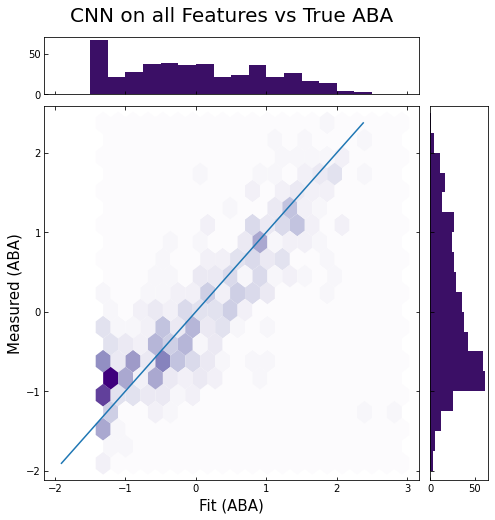

corr is 0.8264950713772424


In [281]:
#FREE ENERGY PLUS ENCODING
X, y = shuffle(X,y)

cutoff = 1800
X_train_free = X[:cutoff, :9*len(perfect_sequence) + 1]
y_train = y[:cutoff]


X_test_free = X[cutoff:, :9*len(perfect_sequence)+ 1]
y_test = y[cutoff:]


model = train(X_train_free, y_train, epochs=100)

ENERGY_ENC_CORR = fit(model, X_test_free, y_test)

input shaped (23, 1, 1)
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 19, 1, 32)         192       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 1, 32)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 192)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 16)                3088      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 17        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
18/18 [==============================] - 0s 2ms/step - loss: 0.3944
Epoch 2/100
1

18/18 [==============================] - 0s 1ms/step - loss: 0.3013
Epoch 90/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3064
Epoch 91/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3022
Epoch 92/100
18/18 [==============================] - 0s 1ms/step - loss: 0.2971
Epoch 93/100
18/18 [==============================] - 0s 1ms/step - loss: 0.2911
Epoch 94/100
18/18 [==============================] - 0s 1ms/step - loss: 0.2832
Epoch 95/100
18/18 [==============================] - 0s 1ms/step - loss: 0.2905
Epoch 96/100
18/18 [==============================] - 0s 1ms/step - loss: 0.2928
Epoch 97/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3123
Epoch 98/100
18/18 [==============================] - 0s 1ms/step - loss: 0.2994
Epoch 99/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3004
Epoch 100/100
18/18 [==============================] - 0s 1ms/step - loss: 0.2914


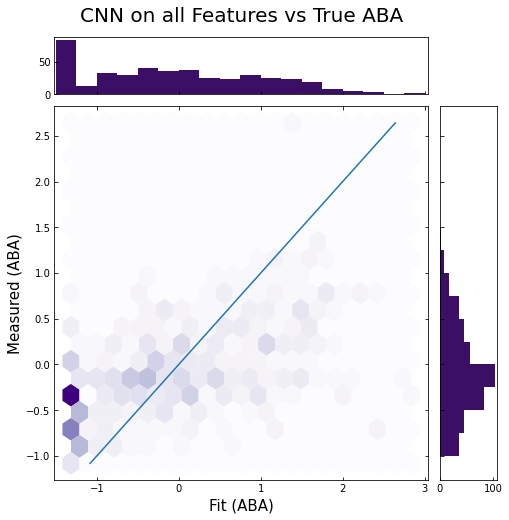

corr is 0.535151044768403


In [282]:
#FREE ENERGY PLUS STRUCTURE
X, y = shuffle(X,y)

cutoff = 1800
X_train_free = X[:cutoff, 9*len(perfect_sequence):10*len(perfect_sequence)+ 1]
y_train = y[:cutoff]


X_test_free = X[cutoff:, 9*len(perfect_sequence):10*len(perfect_sequence)+ 1]
y_test = y[cutoff:]
model = train(X_train_free, y_train, epochs=100)

STRUC_ENERGY_CORR = fit(model, X_test_free, y_test)

input shaped (220, 1, 1)
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 216, 1, 32)        192       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 72, 1, 32)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 16)                36880     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 17        
Total params: 37,089
Trainable params: 37,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
18/18 [==============================] - 0s 5ms/step - loss: 0.3988
Epoch 2/10

18/18 [==============================] - 0s 5ms/step - loss: 0.1014
Epoch 90/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0979
Epoch 91/100
18/18 [==============================] - 0s 4ms/step - loss: 0.1036
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0938
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0924
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0961
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0926
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 0.1006
Epoch 97/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0978
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0961
Epoch 99/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0980
Epoch 100/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0933


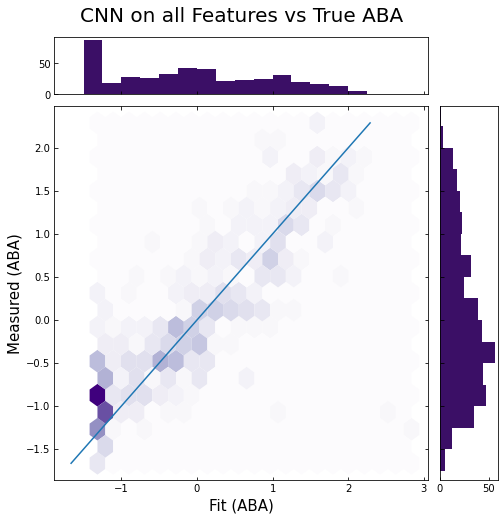

corr is 0.8419260114202544


In [283]:
#STRUCTURE PLUS ENCODING
X, y = shuffle(X,y)

cutoff = 1800
X_train_free = X[:cutoff, [i for i in range(10*len(perfect_sequence)+ 1) if i != 9*len(perfect_sequence)]]
y_train = y[:cutoff]


X_test_free = X[cutoff:, [i for i in range(10*len(perfect_sequence)+ 1) if i != 9*len(perfect_sequence)]]
y_test = y[cutoff:]

model = train(X_train_free, y_train, epochs=100)

ENC_STRUC_CORR = fit(model, X_test_free, y_test)

input shaped (221, 1, 1)
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 217, 1, 32)        192       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 72, 1, 32)         0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 16)                36880     
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 17        
Total params: 37,089
Trainable params: 37,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
18/18 [==============================] - 0s 5ms/step - loss: 0.4182
Epoch 2/10

18/18 [==============================] - 0s 5ms/step - loss: 0.0842
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0796
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0823
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0962
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0822
Epoch 94/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0883
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0875
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0868
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0821
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0874
Epoch 99/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0764
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0757


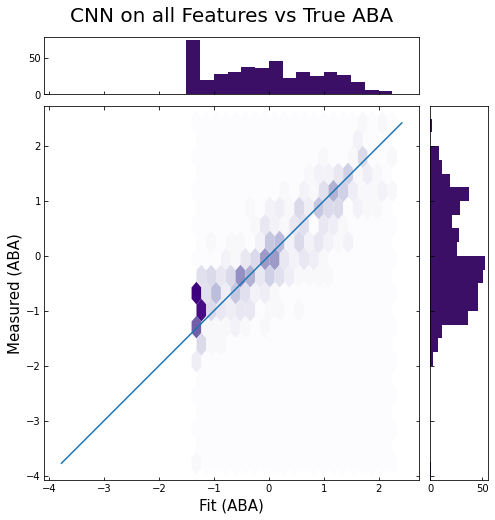

corr is 0.875669310925528


In [288]:
#STRUCTURE PLUS ENCODING PLUS ENERGY
X, y = shuffle(X,y)

cutoff = 1800
X_train_free = X[:cutoff, [i for i in range(10*len(perfect_sequence)+ 1)]]
y_train = y[:cutoff]


X_test_free = X[cutoff:, [i for i in range(10*len(perfect_sequence)+ 1)]]
y_test = y[cutoff:]

model = train(X_train_free, y_train, epochs=100)

ENC_STRUC_ENERGY_CORR = fit(model, X_test_free, y_test)

<Figure size 1440x1440 with 0 Axes>

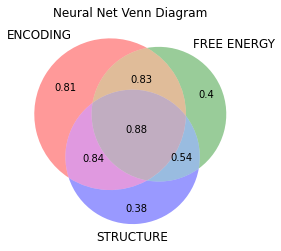

<Figure size 1440x1440 with 0 Axes>

In [289]:
from matplotlib_venn import venn3
plt.title("Neural Net Venn Diagram")
ENC_CORR, ENERGY_CORR, ENERGY_ENC_CORR, STRUC_CORR= (np.round(ENC_CORR,2),np.round(ENERGY_CORR,2),
                                                     np.round(ENERGY_ENC_CORR,2), np.round(STRUC_CORR,2))
ENC_STRUC_CORR, STRUC_ENERGY_CORR, ENC_STRUC_ENERGY_CORR = (np.round(ENC_STRUC_CORR,2),np.round(STRUC_ENERGY_CORR,2),
                                                     np.round(ENC_STRUC_ENERGY_CORR,2))
venn3(subsets = (ENC_CORR, ENERGY_CORR, ENERGY_ENC_CORR, STRUC_CORR,ENC_STRUC_CORR ,
                 STRUC_ENERGY_CORR, ENC_STRUC_ENERGY_CORR), set_labels = ('ENCODING', 'FREE ENERGY', 'STRUCTURE'))
plt.figure(figsize=(20,20))
#plt.show()

# Top feature selection

In [170]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression

/Users/prupes/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


SelectKBest(k='all', score_func=<function f_regression at 0x7fe37428b4c0>)

In [312]:
X, y = create_matrix5(filt_table, perfect_sequence)

#just to show that we aren't really over-fitting
X, y = shuffle(X,y)
cutoff = 1800

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

/Users/prupes/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Feature 0: nan
Feature 1: nan
Feature 2: nan
Feature 3: nan
Feature 4: 0.000392
Feature 5: nan
Feature 6: 50.168748
Feature 7: 2.102815
Feature 8: 7.115035
Feature 9: nan
Feature 10: nan
Feature 11: nan
Feature 12: nan
Feature 13: 2.878271
Feature 14: nan
Feature 15: 76.542206
Feature 16: 71.416283
Feature 17: nan
Feature 18: nan
Feature 19: nan
Feature 20: nan
Feature 21: nan
Feature 22: nan
Feature 23: 24.397581
Feature 24: 53.761567
Feature 25: 20.359860
Feature 26: 3.004791
Feature 27: nan
Feature 28: nan
Feature 29: nan
Feature 30: nan
Feature 31: 14.319388
Feature 32: 3.999802
Feature 33: 30.720652
Feature 34: nan
Feature 35: nan
Feature 36: nan
Feature 37: nan
Feature 38: nan
Feature 39: 9.472227
Feature 40: nan
Feature 41: 38.591024
Feature 42: 51.204331
Feature 43: 13.398605
Feature 44: nan
Feature 45: nan
Feature 46: nan
Feature 47: nan
Feature 48: nan
Feature 49: 12.807135
Feature 50: 38.837492
Feature 51: nan
Feature 52: 3.376203
Feature 53: nan
Feature 54: nan
Feature 55: 

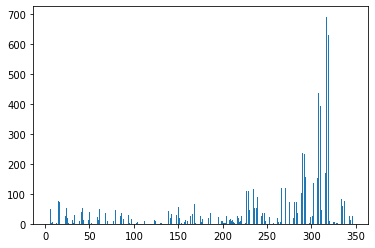

In [313]:
fs = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
fs.fit(X_train, y_train)
# transform train input data
X_train_fs = fs.transform(X_train)
# transform test input data
X_test_fs = fs.transform(X_test)

# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

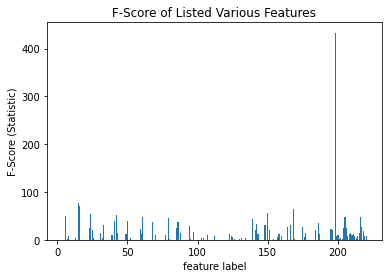

In [314]:
fstats = fs.scores_
non_pool_fs = fstats[:10*len(perfect_sequence)+1]
plt.title("F-Score of Listed Various Features")
plt.ylabel("F-Score (Statistic)")
plt.xlabel("feature label")
plt.bar([i for i in range(len(non_pool_fs))], non_pool_fs)
plt.show()

In [318]:
top_10 = non_pool_fs.argsort()[-10:][::-1]

In [316]:
for i in top_10:
    print(feature_label(i), " ", non_pool_fs[i] )

pos 13 INS G   nan
pos 12 INS A   nan
pos 11 REP G   nan
pos 11 INS T   nan
pos 11 INS G   nan
pos 11 INS C   nan
pos 11 INS A   nan
pos 10 REP G   nan
pos 10 INS T   nan
pos 10 INS G   nan


Feature 0: 0.000518
Feature 1: 0.002019
Feature 2: 0.000000
Feature 3: 0.003081
Feature 4: 0.003455
Feature 5: 0.000000
Feature 6: 0.027986
Feature 7: 0.000000
Feature 8: 0.000000
Feature 9: 0.000000
Feature 10: 0.000000
Feature 11: 0.000000
Feature 12: 0.002678
Feature 13: 0.013440
Feature 14: 0.003851
Feature 15: 0.022686
Feature 16: 0.031440
Feature 17: 0.000000
Feature 18: 0.004172
Feature 19: 0.003428
Feature 20: 0.000000
Feature 21: 0.000000
Feature 22: 0.000000
Feature 23: 0.005208
Feature 24: 0.038694
Feature 25: 0.009924
Feature 26: 0.002389
Feature 27: 0.009515
Feature 28: 0.000000
Feature 29: 0.001525
Feature 30: 0.000000
Feature 31: 0.018753
Feature 32: 0.005937
Feature 33: 0.017727
Feature 34: 0.010203
Feature 35: 0.000000
Feature 36: 0.002479
Feature 37: 0.000000
Feature 38: 0.002733
Feature 39: 0.004039
Feature 40: 0.000000
Feature 41: 0.012236
Feature 42: 0.024545
Feature 43: 0.002358
Feature 44: 0.000000
Feature 45: 0.000000
Feature 46: 0.000175
Feature 47: 0.000000
Fe

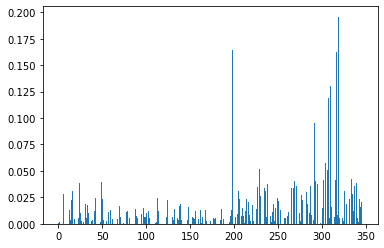

In [171]:
fs = SelectKBest(score_func=mutual_info_regression, k='all')
# learn relationship from training data
fs.fit(X_train, y_train)
# transform train input data
X_train_fs = fs.transform(X_train)
# transform test input data
X_test_fs = fs.transform(X_test)

# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

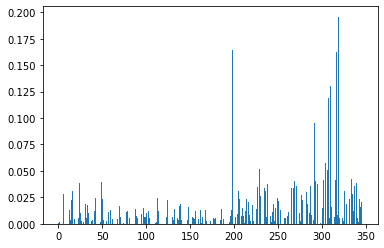

In [290]:
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [174]:
scores = fs.scores_

In [291]:
non_pool_fs = scores[:10*len(perfect_sequence)+1]

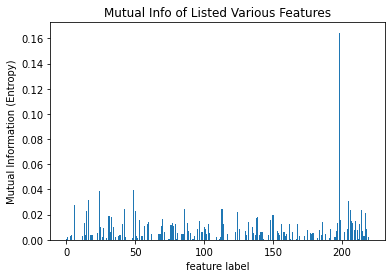

In [294]:
plt.title("Mutual Info of Listed Various Features")
plt.ylabel("Mutual Information (Entropy)")
plt.xlabel("feature label")
plt.bar([i for i in range(len(non_pool_fs))], non_pool_fs)
plt.show()

In [295]:
top_10 = non_pool_fs.argsort()[-10:][::-1]

In [305]:
for i in top_10:
    print(feature_label(i), " ", non_pool_fs[i] )

free energy   0.16447939710045212
pos 6 REP A   0.039469550117950725
pos 3 REP G   0.038693928391640764
pos 2 REP T   0.03143968608865899
paired/free base 7   0.03075606711705081
pos 1 REP G   0.027985670569719234
pos 10 REP C   0.024813543473771738
pos 5 REP G   0.024545496014815704
pos 13 REP C   0.024528671499955745
paired/free base 8   0.02375009806979156


In [175]:
scores[198]

0.16447939710045212